# Twitter Sentiment Analysis

This notebook aims to analyze Tweets made about the COVID-19 vaccine and determine whether the sentiment of the Tweets is negative, positive, or neutral.

## Libraries

In [1]:
import tweepy
import webbrowser
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import time
import numpy as np

import config
pd.set_option('display.max_colwidth', None)

from tweepy import OAuthHandler
from tweepy import API

import os
from google.oauth2 import service_account
from google.cloud import translate_v2 as translate
from google.cloud import language

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk import FreqDist
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk import word_tokenize, TweetTokenizer, FreqDist
import string

import re
from textblob import TextBlob
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cassienutter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Gather data from Twitter API

In [2]:
# Developer API keys
# API keys in config.py in .gitignore
callback_uri = 'oob'

In [3]:
auth = OAuthHandler(config.consumer_key, config.consumer_secret, callback_uri)
auth.set_access_token(config.access_token, config.access_token_secret)

In [4]:
api = API(auth, wait_on_rate_limit= True, wait_on_rate_limit_notify= True)

In [5]:
# show my Twitter handle
me = api.me()
print(me.screen_name)

cassienutter1


In [6]:
# simple query to get the hang of it
query = '#vaccine covid -RT -@ -http'
for i, status in enumerate(tweepy.Cursor(api.search, q= query).items(15)):
    print (i, status.text)

# filter only English tweets    
# query = '#vaccine covid'
# for i, status in enumerate(tweepy.Cursor(api.search, q= query, lang= 'en').items(50)):
#     print (i, status.text)

0 Why some people are getting billed after receiving their COVID vaccine.... and what to do if you get hit with a bil… https://t.co/ZejTdhISsd
1 Saying no to this is our last chance. I'm dead serious. Watch before it's taken down. 🇺🇲

https://t.co/lfCWTIHIBT… https://t.co/XbgqM4OTA9
2 So....the vaccine is supposed to work in the US but not here? 🤷🏻‍♀️🤷🏻‍♀️ #covid #vaccine https://t.co/Uv1HpU25BB
3 Thank you, #PresidentTrump and every single member of the #OperationWarpSpeed team. 

#LuckyBiden #COVID #Vaccine https://t.co/646HaxFLYz
4 LorenceKim, #Moderna VACCINE chief fin officer, exercised 241,000 options for $3 M on Monday, 
filings show

He the… https://t.co/xoXfQ6U84t
5 Join the conversation about the COVID-19 #vaccine.  To register for this event, call 617-349-6220. Talk to the Doc… https://t.co/KgLWqmlPEY
6 Why you should get the first COVID-19 #vaccine offered to you https://t.co/ouEzQ6jJKS
7 Moderna COVID #vaccine offers protection for at least 6 months, study finds @nejm http

In [7]:
''' This cell was run to collect the initial 5000 tweets and save them to a csv file
is commented out to prevent it from being run again


# collect 5000 tweets 
number_of_tweets = 5000
tweets = []
language = []
time = []

# only collect full text, language, and time it was posted
# remove any retweets '-RT'
for i in tweepy.Cursor(api.search, q= 'vaccine covid -RT',  
                       tweet_mode = 'extended').items(number_of_tweets):
    tweets.append(i.full_text)
    language.append(i.lang)
    time.append(i.created_at)

# turn tweets / lists into dataframe
df = pd.DataFrame({'time': time, 'language': language, 'tweets': tweets})

# save df to csv
df.to_csv('data/tweets.csv', index= False)
'''

" This cell was run to collect the initial 5000 tweets and save them to a csv file\nis commented out to prevent it from being run again\n\n\n# collect 5000 tweets \nnumber_of_tweets = 5000\ntweets = []\nlanguage = []\ntime = []\n\n# only collect full text, language, and time it was posted\n# remove any retweets '-RT'\nfor i in tweepy.Cursor(api.search, q= 'vaccine covid -RT',  \n                       tweet_mode = 'extended').items(number_of_tweets):\n    tweets.append(i.full_text)\n    language.append(i.lang)\n    time.append(i.created_at)\n\n# turn tweets / lists into dataframe\ndf = pd.DataFrame({'time': time, 'language': language, 'tweets': tweets})\n\n# save df to csv\ndf.to_csv('data/tweets.csv', index= False)\n"

Collect more tweets after waiting to avoid collecting the same tweets.

In [8]:
# create function to get more tweets and add to existing csv
def get_more_tweets(num_tweets):
    number_of_tweets = num_tweets
    tweets = []
    language = []
    time = []

    # only collect full text, language, and time it was posted
    # remove any retweets '-RT'
    for i in tweepy.Cursor(api.search, q= 'vaccine covid -RT',  
                           tweet_mode = 'extended').items(number_of_tweets):
        tweets.append(i.full_text)
        language.append(i.lang)
        time.append(i.created_at)
        
    # turn tweets / lists into dataframe
    df = pd.DataFrame({'time': time, 'language': language, 'tweets': tweets})
    
    # add to existing csv file
    df.to_csv('data/tweets.csv', mode= 'a', index= False, header= False)

In [9]:
# get tweets and save to csv through function

# n_tweets = 20
# get_more_tweets(n_tweets)

### Search for Tweets from 30 Days Ago

In [10]:
# function to turn results into DataFrame
def extract_text_as_df(text_list):
    columns = set()
    allowed_types = [str, int]
    tweets_data = []
    for status in text_list:
        status_dict = dict(vars(status))
        keys = status_dict.keys()
        single_tweet_data = {"author": status.author.screen_name}
        for k in keys:
            try:
                v_type = type(status_dict[k])
            except:
                v_type = None
            if v_type != None:
                if v_type in allowed_types:
                    single_tweet_data[k] = status_dict[k]
                    columns.add(k)
        tweets_data.append(single_tweet_data)


    header_cols = list(columns)
    header_cols.append('author')
    df = pd.DataFrame(tweets_data, columns=header_cols)
    return df

In [11]:
query = 'vaccine covid -RT'
results_30 = api.search_30_day('datacollection', query, maxResults= 100)

In [12]:
old_results_df = extract_text_as_df(results_30)

In [13]:
old_results_df

,source_url,text,lang,id,in_reply_to_user_id_str,in_reply_to_screen_name,id_str,quote_count,source,retweet_count,filter_level,quoted_status_id,in_reply_to_user_id,in_reply_to_status_id,in_reply_to_status_id_str,reply_count,quoted_status_id_str,favorite_count,author
0,http://twitter.com/download/iphone,@TarotAndTea1 Glad u made it through having COVID!! I can see why the vaccine seemed worth it,en,1379522522320924682,1350022187390910464,TarotAndTea1,1379522522320924682,0,Twitter for iPhone,0,low,NaN,1.350022e+18,1.379468e+18,1379467517735895040,0,NaN,0,BonnieRecchia7
1,http://twitter.com/#!/download/ipad,Canada’s Vaccine Mess #pharma #covid https://t.co/lyNrNWaSpG,en,1379522521289125894,NaN,NaN,1379522521289125894,0,Twitter for iPad,0,low,NaN,NaN,NaN,NaN,0,NaN,0,richmeyer
2,https://mobile.twitter.com,"SK COVID update:\n\n5,938 vaccine doses given.227,471.\n\nFar NW (5), Far NE (11), NW (431), N. Central (349), NE (39),… https://t.co/BRm1snUyo5",en,1379522520370487296,NaN,NaN,1379522520370487296,0,Twitter Web App,0,low,NaN,NaN,NaN,NaN,0,NaN,0,smillsSK
3,https://mobile.twitter.com,https://t.co/GG57ikRIzz\nTexas bans covid-19 vaccine passports.,en,1379522514225934337,NaN,NaN,1379522514225934337,0,Twitter Web App,0,low,NaN,NaN,NaN,NaN,0,NaN,0,MattersSeeking
4,https://mobile.twitter.com,AND 60 per cent of eligible west Cheshire residents have had their first vaccine dose!\nhttps://t.co/lB4IWohc7Y,en,1379522511629606912,NaN,NaN,1379522511629606912,0,Twitter Web App,0,low,NaN,NaN,NaN,NaN,0,NaN,0,FrodshamNub
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,https://mobile.twitter.com,@78asw We are delivering the maximum of vaccines based on what is delivered to us from the Province. I cannot verif… https://t.co/IzqBMrfSSN,en,1379522004500504576,1038158705890656261,78asw,1379522004500504576,0,Twitter Web App,0,low,NaN,1.038159e+18,1.379444e+18,1379443614238015489,0,NaN,0,LGLHealthUnit
96,http://twitter.com/#!/download/ipad,"@JustBob10 @DJSiri FFS All deaths no matter what from, cancer, heart disease a rock falling from the sky were recor… https://t.co/UNIEcusnJa",en,1379522002587942912,1348609017900314624,JustBob10,1379522002587942912,0,Twitter for iPad,0,low,NaN,1.348609e+18,1.379521e+18,1379520895757193225,0,NaN,0,Vinnyports
97,http://twitter.com/download/iphone,https://t.co/c74UENIw3n \nHahahahaha,tl,1379521990311227393,NaN,NaN,1379521990311227393,0,Twitter for iPhone,0,low,NaN,NaN,NaN,NaN,0,NaN,0,angelswoke
98,http://twitter.com/download/iphone,"I thought a side effect of the covid vaccine is that it makes you sexy , but I already had that as a pre-existing condition",en,1379521989954707460,NaN,NaN,1379521989954707460,0,Twitter for iPhone,0,low,NaN,NaN,NaN,NaN,1,NaN,3,calebrn01v2


## Data Cleaning & EDA

In [14]:
df = pd.read_csv('data/tweets.csv')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19450 entries, 0 to 19449
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   time      19450 non-null  object
 1   language  19450 non-null  object
 2   tweets    19450 non-null  object
dtypes: object(3)
memory usage: 456.0+ KB


### Check and Remove Duplicates

In [16]:
# check for duplicated tweets
duped = df[df.duplicated(subset= 'tweets')]
duped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 812 to 19444
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   time      52 non-null     object
 1   language  52 non-null     object
 2   tweets    52 non-null     object
dtypes: object(3)
memory usage: 1.6+ KB


In [17]:
# remove duplicates
df.drop_duplicates(subset= 'tweets', keep= 'first', inplace= True)
df.reset_index(drop= True, inplace= True)

# make sure they are gone
df.tweets.duplicated().sum()

0

In [18]:
df.head(15)

,time,language,tweets
0,2021-04-01 21:58:45,en,"Concerning the use of aborted baby tissue in the J&amp;J Covid vaccine:\n\n“The J&amp;J vaccine has sparked debate among some religious communities because it was developed from stem cells obtained during two abortions decades ago.”\n\nEvil is still evil, even if it was decades ago."
1,2021-04-01 21:58:44,und,@and_kell @ds13_manon https://t.co/sKnTctMKcF
2,2021-04-01 21:58:43,pt,Estão vacinando 3 MILHÕES de pessoas por dia nesse país. Não é possível uma coisa dessa. https://t.co/iNP7RvWsat
3,2021-04-01 21:58:42,en,imagine an animal getting the covid-19 vaccine b4 a human
4,2021-04-01 21:58:40,en,Definition of a microstate: https://t.co/8N0R8Mhl73\n\nSource of vaccine data: https://t.co/0RQFJPTrZZ
5,2021-04-01 21:58:33,en,"If I’ve Had COVID-19, Do I Still Need Two Doses of Vaccine? https://t.co/08AiBgfEHQ"
6,2021-04-01 21:58:31,en,"My epidural was delayed again, somehow my covid vaccine does not interact well with an epidural. SOOOOO I should be getting it on my birthday. Yay. \n\n So far I have 1-2 dr appointments a week this entire month.\n \nOn the upside they've given me proper muscle relaxers this time."
7,2021-04-01 21:58:31,en,Blake Lively hilariously called out her husband Ryan Reynolds for what he posted after they got their COVID-19 vaccine shots https://t.co/GixfzNnHBc
8,2021-04-01 21:58:30,en,@Kit_Yates_Maths Tests\n1. Vax deployment ✅✅\n2. Vax reduces hospitalisation ✅✅\n3. Infection rates unsubstantiated pressure on NHS ✅\n4. Variants of concern ☑️\n\nSo not measured but very conservative \nhttps://t.co/iVMKF2pPsF https://t.co/ta4t21HH9s
9,2021-04-01 21:58:30,en,Here’s how you can be forced to get the Covid vaccine in the US https://t.co/dparLwxbq2


### Looking at Languages

In [19]:
lang_df = df.sort_values('language')

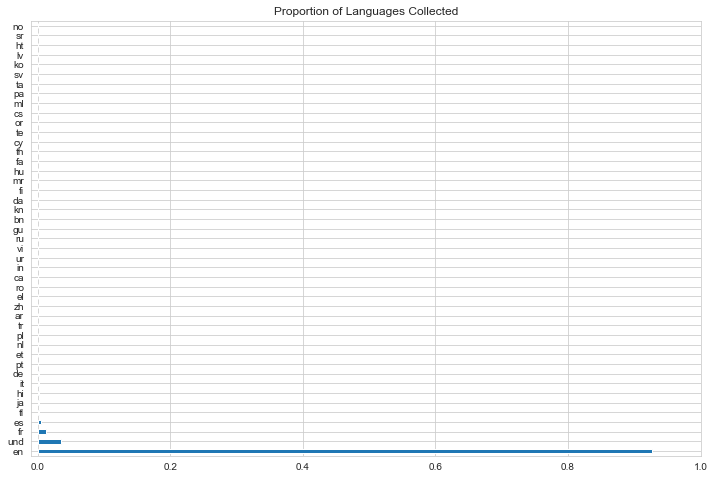

In [20]:
plt.figure(figsize= (12, 8))
lang_df.language.value_counts(normalize=True).plot(kind= 'barh')
plt.title('Proportion of Languages Collected')
plt.xlim(-.01, 1)
plt.show()

In [21]:
lang_df.language.value_counts(normalize=True)

en     0.926333
und    0.035725
fr     0.011857
es     0.004485
tl     0.002371
ja     0.002062
hi     0.002011
it     0.001392
de     0.001340
pt     0.001186
et     0.001083
nl     0.000928
pl     0.000722
tr     0.000670
ar     0.000619
zh     0.000464
el     0.000464
ro     0.000464
ca     0.000412
in     0.000412
ur     0.000412
vi     0.000412
ru     0.000361
gu     0.000361
bn     0.000309
kn     0.000309
da     0.000309
fi     0.000258
mr     0.000258
hu     0.000206
fa     0.000206
th     0.000155
cy     0.000155
te     0.000155
or     0.000155
cs     0.000155
ml     0.000155
pa     0.000103
ta     0.000103
sv     0.000103
ko     0.000103
lv     0.000103
ht     0.000052
sr     0.000052
no     0.000052
Name: language, dtype: float64

In [22]:
# what are these languages? get table from url
URL = 'https://developer.twitter.com/en/docs/twitter-for-websites/supported-languages'
tables = pd.read_html(URL)
print("There are : ",len(tables)," tables")
print(tables[0])

lang_table = tables[0]

There are :  1  tables
                        0              1
0                    Name  Language code
1       English (default)             en
2                  Arabic             ar
3                 Bengali             bn
4                   Czech             cs
5                  Danish             da
6                  German             de
7                   Greek             el
8                 Spanish             es
9                 Persian             fa
10                Finnish             fi
11               Filipino            fil
12                 French             fr
13                 Hebrew             he
14                  Hindi             hi
15              Hungarian             hu
16             Indonesian             id
17                Italian             it
18               Japanese             ja
19                 Korean             ko
20                  Malay            msa
21                  Dutch             nl
22              Norwegian         

In [23]:
# format table
header_row = 0
lang_table.columns = lang_table.iloc[header_row]
lang_table = lang_table.drop(header_row)
lang_table.reset_index(drop= True, inplace= True)

lang_table.replace('English (default)', 'English', inplace= True)
# lang_table

In [24]:
# save as csv in data folder
lang_table.to_csv('data/languages.csv', index= False)

In [25]:
# look at 'und' language 
df[df['language'] == 'und']

,time,language,tweets
1,2021-04-01 21:58:44,und,@and_kell @ds13_manon https://t.co/sKnTctMKcF
19,2021-04-01 21:58:14,und,https://t.co/j2braq4wFx
29,2021-04-01 21:57:58,und,@Pavlos80322302 @ds13_manon https://t.co/sKnTctMKcF
79,2021-04-01 21:56:21,und,👍🏼👍🏼👍🏼👍🏼 https://t.co/m68KkEqpOe
97,2021-04-01 21:55:44,und,https://t.co/Stomi0I13k
...,...,...,...
19289,2021-04-04 16:40:46,und,@deniseramosm https://t.co/Hi3OGdXTeP\n⬇️
19317,2021-04-04 16:39:30,und,https://t.co/WRugcVZRqr
19372,2021-04-04 16:37:17,und,الحمدلله 🙏🏽💉 (@ COVID-19 Vaccine Center - @saudimoh in الرياض) https://t.co/zfzBWyp4Tg
19373,2021-04-04 16:37:14,und,https://t.co/J54pSG93KG


It appears that the 'und' or possibly 'undetermined' language are tweets that do not include text to help us with our sentiment analysis. We will remove those from our DataFrame.

In [26]:
df = df[df['language'] != 'und']
# df.info()

Merge the data with the languages to see the whole name of languages

In [27]:
# merge data with language names
df2 = df.merge(lang_table, how= 'inner', left_on= 'language', right_on= 'Language code')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18575 entries, 0 to 18574
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   time           18575 non-null  object
 1   language       18575 non-null  object
 2   tweets         18575 non-null  object
 3   Name           18575 non-null  object
 4   Language code  18575 non-null  object
dtypes: object(5)
memory usage: 870.7+ KB


In [28]:
# drop extra columns and rename them and change dates to datetime and drop time
df2.drop(columns = ['language', 'Language code'], inplace= True)
df2.rename(columns={'Name': 'language'}, inplace= True)
df2['time'] = pd.to_datetime(df2['time']).dt.date
# df2

Let's see how many Tweets are in each language?

<AxesSubplot:xlabel='count', ylabel='language'>

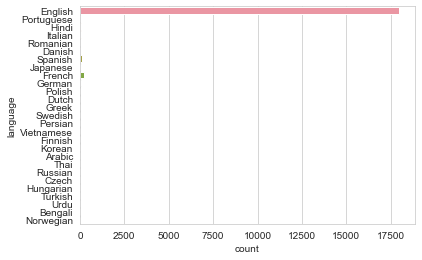

In [29]:
sns.countplot(y= 'language', data= df2)

The majority of Tweets are in English. Let's see what the other languages are.

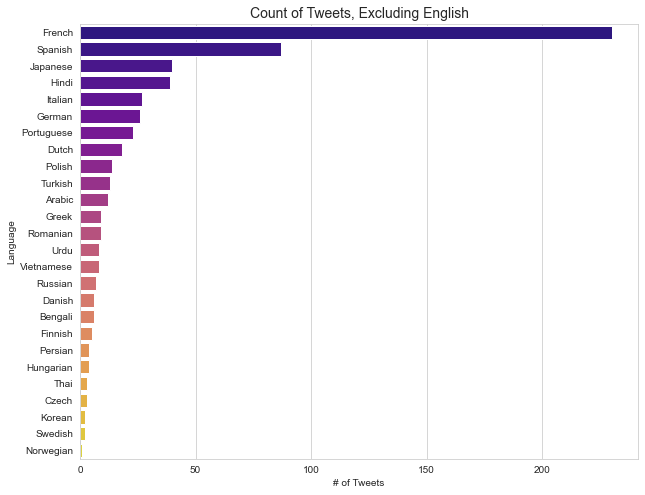

In [30]:
# countplot that excludes English to see detail
plt.figure(figsize= (10, 8))
sns.countplot(y= 'language', data= df2, palette='plasma',
              order= df2.language.value_counts().iloc[1:].index)
plt.title('Count of Tweets, Excluding English', fontsize= 14)
plt.xlabel('# of Tweets')
plt.ylabel('Language')
plt.show()

After English, the top 3 languages for Tweets about the COVID-19 vaccine are in French, Spanish, and Japanese.

In [31]:
df2.head(10)

,time,tweets,language
0,2021-04-01,"Concerning the use of aborted baby tissue in the J&amp;J Covid vaccine:\n\n“The J&amp;J vaccine has sparked debate among some religious communities because it was developed from stem cells obtained during two abortions decades ago.”\n\nEvil is still evil, even if it was decades ago.",English
1,2021-04-01,imagine an animal getting the covid-19 vaccine b4 a human,English
2,2021-04-01,Definition of a microstate: https://t.co/8N0R8Mhl73\n\nSource of vaccine data: https://t.co/0RQFJPTrZZ,English
3,2021-04-01,"If I’ve Had COVID-19, Do I Still Need Two Doses of Vaccine? https://t.co/08AiBgfEHQ",English
4,2021-04-01,"My epidural was delayed again, somehow my covid vaccine does not interact well with an epidural. SOOOOO I should be getting it on my birthday. Yay. \n\n So far I have 1-2 dr appointments a week this entire month.\n \nOn the upside they've given me proper muscle relaxers this time.",English
5,2021-04-01,Blake Lively hilariously called out her husband Ryan Reynolds for what he posted after they got their COVID-19 vaccine shots https://t.co/GixfzNnHBc,English
6,2021-04-01,@Kit_Yates_Maths Tests\n1. Vax deployment ✅✅\n2. Vax reduces hospitalisation ✅✅\n3. Infection rates unsubstantiated pressure on NHS ✅\n4. Variants of concern ☑️\n\nSo not measured but very conservative \nhttps://t.co/iVMKF2pPsF https://t.co/ta4t21HH9s,English
7,2021-04-01,Here’s how you can be forced to get the Covid vaccine in the US https://t.co/dparLwxbq2,English
8,2021-04-01,"I received my second dose of the Covid-19 vaccine today. I’m grateful, and hopeful for a return to normalcy on the horizon. I want to thank everyone working so hard to get folks vaccinated. Get your vaccine here: https://t.co/YAl9dOBkLo #GetYourShot #vaccinated https://t.co/WH5AdwbgkP",English
9,2021-04-01,@JoshMatlow Ok how many times has this How do we have vaccine clinics in areas where Covid cases are highest ?\nOr most important paid sick leave?\nPlease Mr Matlow what we can we the ordinary citizen do? It seems you are unable to do anything? I am pleading with you do something!,English


#### Translate to English using Google Cloud Platform's API

**Most of this section has been commented out to prevent running on Google Cloud.**

In [32]:
# send in credentials that are saved on local computer
credentials = service_account.Credentials.from_service_account_file('../GCP_service_account.json')
translate_client = translate.Client(credentials = credentials)

In [33]:
# see all languages that Google can translate
print(translate_client.get_languages())

[{'language': 'af', 'name': 'Afrikaans'}, {'language': 'sq', 'name': 'Albanian'}, {'language': 'am', 'name': 'Amharic'}, {'language': 'ar', 'name': 'Arabic'}, {'language': 'hy', 'name': 'Armenian'}, {'language': 'az', 'name': 'Azerbaijani'}, {'language': 'eu', 'name': 'Basque'}, {'language': 'be', 'name': 'Belarusian'}, {'language': 'bn', 'name': 'Bengali'}, {'language': 'bs', 'name': 'Bosnian'}, {'language': 'bg', 'name': 'Bulgarian'}, {'language': 'ca', 'name': 'Catalan'}, {'language': 'ceb', 'name': 'Cebuano'}, {'language': 'ny', 'name': 'Chichewa'}, {'language': 'zh-CN', 'name': 'Chinese (Simplified)'}, {'language': 'zh-TW', 'name': 'Chinese (Traditional)'}, {'language': 'co', 'name': 'Corsican'}, {'language': 'hr', 'name': 'Croatian'}, {'language': 'cs', 'name': 'Czech'}, {'language': 'da', 'name': 'Danish'}, {'language': 'nl', 'name': 'Dutch'}, {'language': 'en', 'name': 'English'}, {'language': 'eo', 'name': 'Esperanto'}, {'language': 'et', 'name': 'Estonian'}, {'language': 'tl'

In [34]:
# separate non-English tweets for faster translating
part_df = df2.loc[16100:]
# part_df.language.value_counts(normalize= True)

In [35]:
# create dictionary to save original tweet and translated one
# commented out to prevent re-running on Google Cloud
'''
results = {}

# translate tweets into English
for i in part_df.tweets.loc[:]:
    result = translate_client.translate(i, target_language= 'en')
    results[i] = result['translatedText']
'''

"\nresults = {}\n\n# translate tweets into English\nfor i in part_df.tweets.loc[:]:\n    result = translate_client.translate(i, target_language= 'en')\n    results[i] = result['translatedText']\n"

In [36]:
# replace with English translation
# df2.tweets.replace(results, inplace= True)

In [37]:
# preview previously French Tweets
# df2[df2['language'] == 'French']

In [38]:
# save to csv file
# df2.to_csv('data/tweets_translated.csv', index= False)

## Text Sentiment
---
Does the tweet have a positive, negative, or neutral tone?

### Feature Engineering for Text Data
--- 
stopword removal
frequency distributions
lemmatization
bigramsm n-grams, and mutal information score

In [39]:
# load data from csv
df2 = pd.read_csv('data/tweets_translated.csv')

In [40]:
# remove language column
sentiment_df = df2[['time', 'tweets']]
sentiment_df.head()

,time,tweets
0,2021-04-01,"Concerning the use of aborted baby tissue in the J&amp;J Covid vaccine:\n\n“The J&amp;J vaccine has sparked debate among some religious communities because it was developed from stem cells obtained during two abortions decades ago.”\n\nEvil is still evil, even if it was decades ago."
1,2021-04-01,imagine an animal getting the covid-19 vaccine b4 a human
2,2021-04-01,Definition of a microstate: https://t.co/8N0R8Mhl73\n\nSource of vaccine data: https://t.co/0RQFJPTrZZ
3,2021-04-01,"If I’ve Had COVID-19, Do I Still Need Two Doses of Vaccine? https://t.co/08AiBgfEHQ"
4,2021-04-01,"My epidural was delayed again, somehow my covid vaccine does not interact well with an epidural. SOOOOO I should be getting it on my birthday. Yay. \n\n So far I have 1-2 dr appointments a week this entire month.\n \nOn the upside they've given me proper muscle relaxers this time."


### Google Cloud Platform Natural Language Processing

In [41]:
# input credentials from local file to access Google Cloud Platform
credentials = service_account.Credentials.from_service_account_file('../GCP_service_account.json')
nlp_client = language.Client(credentials = credentials)

In [42]:
# function to collect sentiment from Google Cloud
scores = []
magnitudes = []

def getGoogleSentiments(txt):
    document = nlp_client.document_from_text(txt)
    
    sent_analysis = document.analyze_sentiment()
    sentiment = sent_analysis.sentiment
    
    # get score and magnitude and add to list
    score = sentiment.score
    scores.append(score)
    magnitude = sentiment.magnitude
    magnitudes.append(magnitude)
    # add delay to prevent hitting rate limit
    time.sleep(5)


In [43]:
# get sentiment score and magnitude from function
# google_sent = sentiment_df.tweets.apply(getGoogleSentiments)

Unfortunately, I hit the free trial limit and was unable to utilize the service. There were 5546 scores and magnitudes that were added to a partial DataFrame.

_Google Cloud's Natural Language sentiment analysis markers:_

**Score** of the sentiment ranges between -1.0 (negative) and 1.0 (positive) and corresponds to the overall emotional leaning of the text.

**Magnitude** indicates the overall strength of emotion (both positive and negative) within the given text, between 0.0 and +inf. Unlike score, magnitude is not normalized; each expression of emotion within the text (both positive and negative) contributes to the text's magnitude (so longer text blocks may have greater magnitudes).

In [44]:
''' This cell has been commented out, was created when Google Cloud code ran -  
saved list items to DataFrame and saved to csv

sentiment_part = sentiment_df[:5546]
sentiment_partial = sentiment_part.copy()

# add lists to DataFrame as new columns
sentiment_partial['Google Score'] = scores
sentiment_partial['Google Magnitude'] = magnitudes

# function to determine if Tweet was positive, negative, or neutral
def getTextAnalysis(p):
    if p < 0:
        return 'Negative'
    elif p == 0:
        return 'Neutral'
    else:
        return 'Positive'

sentiment_partial['Google Sentiment'] = sentiment_partial['Google Score'].apply(getTextAnalysis)

# save to csv file
sentiment_partial.to_csv('data/tweets_google_sentiment.csv', index= False)
'''

" This cell has been commented out, was created when Google Cloud code ran -  \nsaved list items to DataFrame and saved to csv\n\nsentiment_part = sentiment_df[:5546]\nsentiment_partial = sentiment_part.copy()\n\n# add lists to DataFrame as new columns\nsentiment_partial['Google Score'] = scores\nsentiment_partial['Google Magnitude'] = magnitudes\n\n# function to determine if Tweet was positive, negative, or neutral\ndef getTextAnalysis(p):\n    if p < 0:\n        return 'Negative'\n    elif p == 0:\n        return 'Neutral'\n    else:\n        return 'Positive'\n\nsentiment_partial['Google Sentiment'] = sentiment_partial['Google Score'].apply(getTextAnalysis)\n\n# save to csv file\nsentiment_partial.to_csv('data/tweets_google_sentiment.csv', index= False)\n"

In [45]:
# load csv file to plot
google_partial = pd.read_csv('data/tweets_google_sentiment.csv')

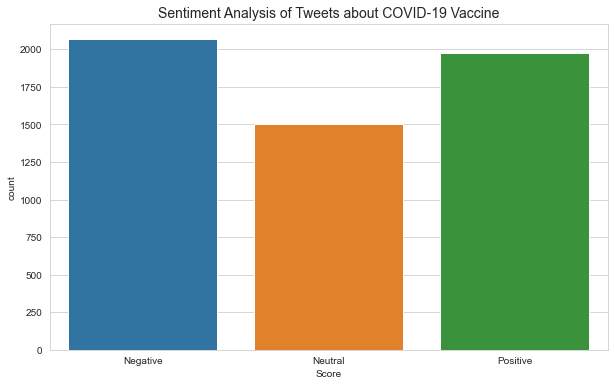

In [46]:
# plot as bar graph
plt.figure(figsize= (10, 6))
sns.countplot(data= google_partial, x = 'Google Sentiment')
plt.title('Sentiment Analysis of Tweets about COVID-19 Vaccine', fontsize = 14)
plt.xlabel('Score')
plt.show()

The classifications are fairly balanced.

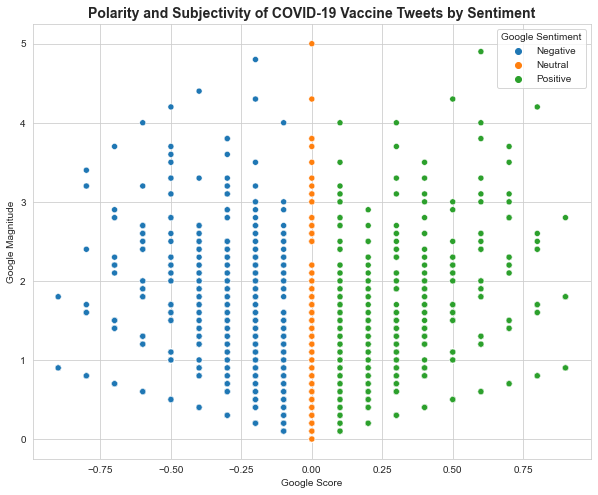

In [47]:
# plot polarity and subjectivity and sentiment of the Tweet
plt.figure(figsize= (10,8))
sns.scatterplot(x= 'Google Score', y= 'Google Magnitude', data= google_partial, hue= 'Google Sentiment')
plt.title('Polarity and Subjectivity of COVID-19 Vaccine Tweets by Sentiment', 
          fontsize = 14, fontweight= 'bold')
plt.show()

The symmetry of scores and magnitudes is impressive!

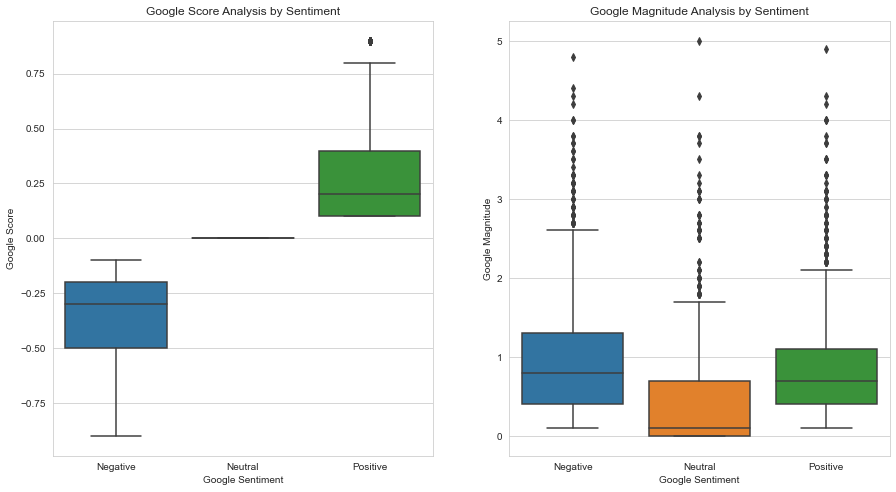

In [48]:
# make boxplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (15,8))

sns.boxplot(x= 'Google Sentiment', y= 'Google Score', 
            data= google_partial, ax= ax1)

sns.boxplot(x= 'Google Sentiment', y= 'Google Magnitude', 
            data= google_partial, ax= ax2)
ax1.set_title('Google Score Analysis by Sentiment')
ax2.set_title('Google Magnitude Analysis by Sentiment')
plt.show()

### Sentiment Analysis with TextBlob

In [49]:
sentiment_df = pd.read_csv('data/tweets_translated.csv')

In [50]:
# functions to clean tweets, get subjectivity and polarity scores and sentiment
def cleanTweet(txt):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(amp)", 
                           " ", str(txt)).split())

def getTextSubjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

def getTextPolarity(txt):
    return TextBlob(txt).sentiment.polarity

# function to determine if Tweet was positive, negative, or neutral
def getTextAnalysis(p):
    if p < 0:
        return 'Negative'
    elif p == 0:
        return 'Neutral'
    else:
        return 'Positive'

_In TextBlob:_

**Subjectivity** - Subjective sentences generally refer to personal opinion, emotion 
    or judgment whereas objective refers to factual information. 
    Subjectivity is also a float which lies in the range of (0,1)
    
**Polarity** - a float which lies in the range of (-1,1) 
    where 1 means positive statement and -1 means a negative statement

In [51]:
# apply functions to tweets
sentiment_df['tweets'] = sentiment_df['tweets'].apply(cleanTweet)
sentiment_df['TB Subjectivity'] = sentiment_df['tweets'].apply(getTextSubjectivity)
sentiment_df['TB Polarity'] = sentiment_df['tweets'].apply(getTextPolarity)
sentiment_df['TB Sentiment'] = sentiment_df['TB Polarity'].apply(getTextAnalysis)
sentiment_df

,time,tweets,language,TB Subjectivity,TB Polarity,TB Sentiment
0,2021-04-01,Concerning the use of aborted baby tissue in the J J Covid vaccine The J J vaccine has sparked debate among some religious communities because it was developed from stem cells obtained during two abortions decades ago Evil is still evil even if it was decades ago,English,0.637500,-0.475000,Negative
1,2021-04-01,imagine an animal getting the covid 19 vaccine b4 a human,English,0.100000,0.000000,Neutral
2,2021-04-01,Definition of a microstate Source of vaccine data,English,0.000000,0.000000,Neutral
3,2021-04-01,If I ve Had COVID 19 Do I Still Need Two Doses of Vaccine,English,0.000000,0.000000,Neutral
4,2021-04-01,My epidural was delayed again somehow my covid vaccine does not interact well with an epidural SOOOOO I should be getting it on my birthday Yay So far I have 1 2 dr appointments a week this entire month On the upside they ve given me proper muscle relaxers this time,English,0.575000,0.033333,Positive
...,...,...,...,...,...,...
18570,2021-04-02,Umrah can be performed without vaccination in Ramadan PuberKalom umrah Hajj Ramdan SaudiArabia Covid Vaccine,Bengali,0.000000,0.000000,Neutral
18571,2021-04-03,Nurse busy on mobile one person was vaccinated twice PuberKalom Mobile Covid vaccine UttarPradesh nurses,Bengali,0.300000,0.100000,Positive
18572,2021-04-03,While talking on the phone the nurse vaccinated the woman not to take 2 doses at once then Coronavirus CoronaVaccine News18Bangla,Bengali,0.000000,0.000000,Neutral
18573,2021-04-04,Covid 19 Vaccine Registration Easy way to register for Corona Vaccine Coronavirus Covid 19 AagrogyaSetu,Bengali,0.833333,0.433333,Positive


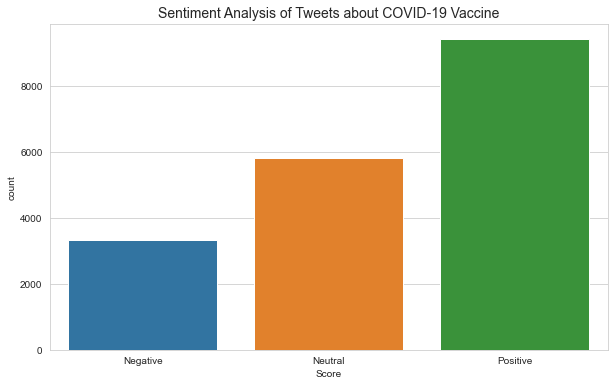

In [52]:
# plot as bar graph
plt.figure(figsize= (10, 6))
sns.countplot(data= sentiment_df, x = 'TB Sentiment')
plt.title('Sentiment Analysis of Tweets about COVID-19 Vaccine', fontsize = 14)
plt.xlabel('Score')
plt.show()

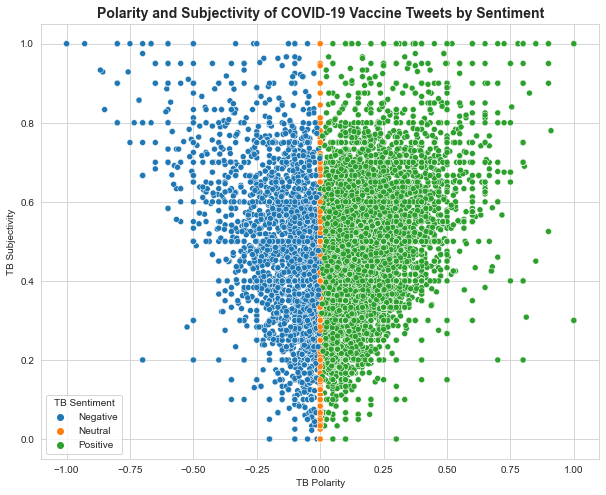

In [53]:
# plot polarity and subjectivity and sentiment of the Tweet
plt.figure(figsize= (10,8))
sns.scatterplot(x= 'TB Polarity', y= 'TB Subjectivity', data= sentiment_df, hue= 'TB Sentiment')
plt.title('Polarity and Subjectivity of COVID-19 Vaccine Tweets by Sentiment', 
          fontsize = 14, fontweight= 'bold')
plt.show()

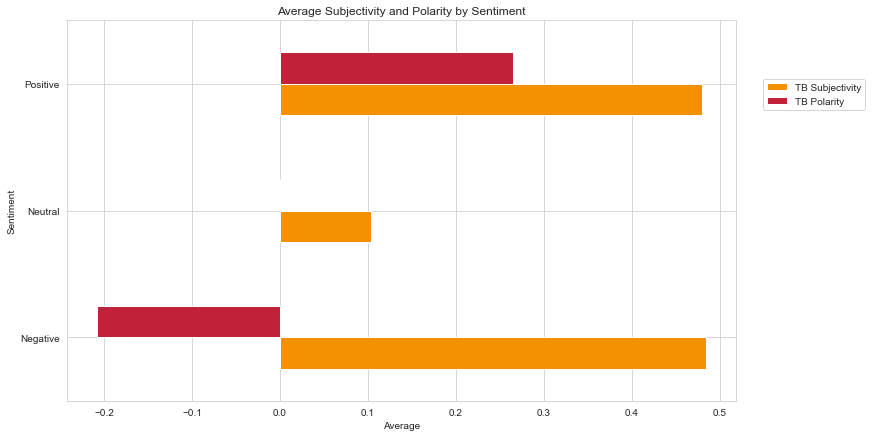

In [54]:
# plot averages
sentiment_df.groupby(['TB Sentiment']).mean().plot(kind= 'barh', 
                                                   figsize= (12,7), 
                                                   color= ['#f49103', '#c2213a'])

plt.title('Average Subjectivity and Polarity by Sentiment', fontsize = 12)
plt.ylabel('Sentiment')
plt.xlabel('Average')
plt.legend(loc= 'lower right', bbox_to_anchor= (1.2, .75))
plt.show()

Since the criteria for a neutral Tweet was a polarity = 0, neutral Tweets have no polarity

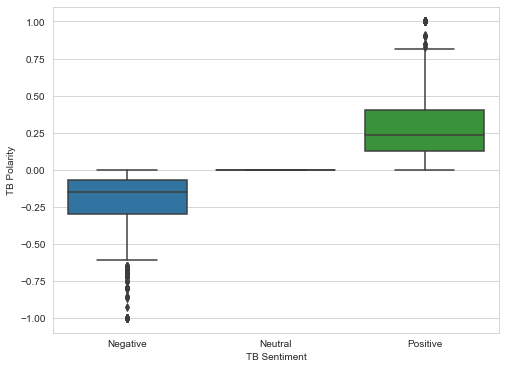

In [55]:
# other way to view above chart without subjectivity
plt.figure(figsize= (8, 6))
sns.boxplot(x= 'TB Sentiment', y= 'TB Polarity', data= sentiment_df)
plt.show()

In [56]:
sentiment_df.groupby(['TB Sentiment']).mean()

,TB Subjectivity,TB Polarity
TB Sentiment,,
Negative,0.484252,-0.207922
Neutral,0.103298,0.000000
Positive,0.479817,0.265269


* There are about 3 times more positive Tweets than negative ones
* Positive and negative Tweets have very similar Subjectivity scores (referring to opinions rather than facts)
* Positive Tweets have a higher polarity than negative Tweets (positive Tweets are more positive than negative Tweets are negative)

In [57]:
# save all to csv
# sentiment_df.to_csv('data/tweets_sentiment_data.csv', index= False)

### Word Cloud, Word Freqency and Bigram

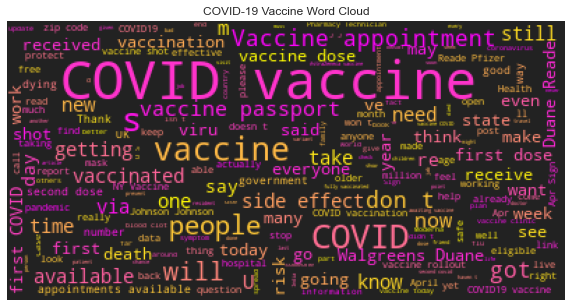

In [58]:
# create word cloud
words = ' '.join([tweet for tweet in sentiment_df['tweets']])
wc = WordCloud(background_color= '#222222').generate(words)
plt.figure(figsize= (10, 6))
plt.imshow(wc.recolor(colormap= 'spring'))
plt.axis('off')
plt.title('COVID-19 Vaccine Word Cloud')
plt.show()

In [59]:
# tokenizing
tokens = sentiment_df['tweets'].map(word_tokenize)
tokens

0               [Concerning, the, use, of, aborted, baby, tissue, in, the, J, J, Covid, vaccine, The, J, J, vaccine, has, sparked, debate, among, some, religious, communities, because, it, was, developed, from, stem, cells, obtained, during, two, abortions, decades, ago, Evil, is, still, evil, even, if, it, was, decades, ago]
1                                                                                                                                                                                                                                                                 [imagine, an, animal, getting, the, covid, 19, vaccine, b4, a, human]
2                                                                                                                                                                                                                                                                            [Definition, of, a, microstate, Source, of, vaccine, data]
3               

In [60]:
# create stopwords list
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

In [61]:
 # remove stop words make make all words lowercase
stopped_data = [w.lower() for l in tokens for w in l if w not in stopwords_list]
print(len(stopped_data))
# stopped_data

315170


['concerning',
 'use',
 'aborted',
 'baby',
 'tissue',
 'j',
 'j',
 'covid',
 'vaccine',
 'the',
 'j',
 'j',
 'vaccine',
 'sparked',
 'debate',
 'among',
 'religious',
 'communities',
 'developed',
 'stem',
 'cells',
 'obtained',
 'two',
 'abortions',
 'decades',
 'ago',
 'evil',
 'still',
 'evil',
 'even',
 'decades',
 'ago',
 'imagine',
 'animal',
 'getting',
 'covid',
 '19',
 'vaccine',
 'b4',
 'human',
 'definition',
 'microstate',
 'source',
 'vaccine',
 'data',
 'if',
 'i',
 'had',
 'covid',
 '19',
 'do',
 'i',
 'still',
 'need',
 'two',
 'doses',
 'vaccine',
 'my',
 'epidural',
 'delayed',
 'somehow',
 'covid',
 'vaccine',
 'interact',
 'well',
 'epidural',
 'sooooo',
 'i',
 'getting',
 'birthday',
 'yay',
 'so',
 'far',
 'i',
 '1',
 '2',
 'dr',
 'appointments',
 'week',
 'entire',
 'month',
 'on',
 'upside',
 'given',
 'proper',
 'muscle',
 'relaxers',
 'time',
 'blake',
 'lively',
 'hilariously',
 'called',
 'husband',
 'ryan',
 'reynolds',
 'posted',
 'got',
 'covid',
 '19',


In [62]:
# show 20 most common words
words_freq = FreqDist(stopped_data)
freq_words_20 = words_freq.most_common(20)

In [63]:
freq_words_20

[('vaccine', 17816),
 ('covid', 15696),
 ('19', 6095),
 ('i', 5619),
 ('get', 2851),
 ('the', 2266),
 ('people', 2142),
 ('vaccines', 1273),
 ('got', 1250),
 ('first', 1234),
 ('dose', 1202),
 ('getting', 1176),
 ('vaccinated', 1152),
 ('one', 1094),
 ('appointments', 1056),
 ('available', 1023),
 ('pfizer', 986),
 ('it', 941),
 ('new', 928),
 ('like', 927)]

In [110]:
# function to show numbers on plot
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

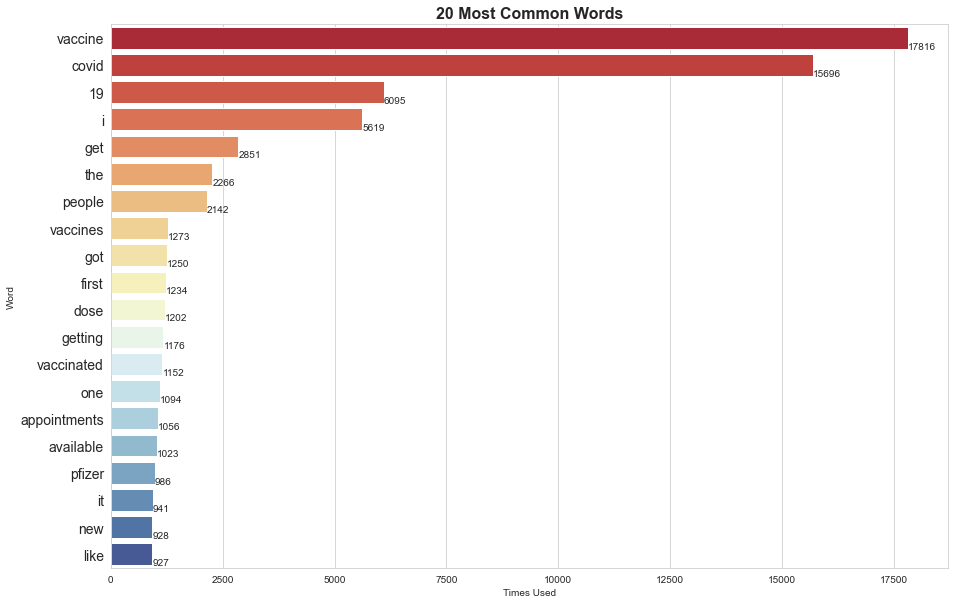

In [113]:
# separate elements to plot
x_val = [x[0] for x in freq_words_20]
y_val = [x[1] for x in freq_words_20]

# plot 20 most frequent words
plt.figure(figsize= (15, 10))
graph = sns.barplot(y = x_val, x= y_val, palette= 'RdYlBu')

# function used to show counts on plot
show_values_on_bars(graph, 'h', 0.6)

plt.title('20 Most Common Words', fontsize = 16, fontweight= 'bold')
plt.xlabel('Times Used')
plt.yticks(fontsize= 14)
plt.ylabel('Word')
plt.show()

In [65]:
#bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()

tweets_finder = nltk.collocations.BigramCollocationFinder.from_words(stopped_data)

tweets_scored = tweets_finder.score_ngrams(bigram_measures.raw_freq)
tweets_scored[:10]

[(('covid', '19'), 0.019116667195481805),
 (('covid', 'vaccine'), 0.015693117999809627),
 (('19', 'vaccine'), 0.012253704350033316),
 (('vaccine', 'appointments'), 0.0025922518006155407),
 (('get', 'covid'), 0.0024018783513659295),
 (('appointments', 'available'), 0.0022940000634578163),
 (('available', 'walgreens'), 0.00195767363645017),
 (('vaccine', 'passports'), 0.0018244122219754418),
 (('side', 'effects'), 0.0017799917504838659),
 (('vaccine', 'i'), 0.0015198147031760638)]

### Differences from Google and TextBlob

In [66]:
# sentiment_df = pd.read_csv('data/text_sentiment_TextBlob.csv')

In [67]:
temp_part = sentiment_df[:5546]
tb_part = temp_part[['TB Sentiment']]
tb_partial = tb_part.copy()

In [68]:
tb_partial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5546 entries, 0 to 5545
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   TB Sentiment  5546 non-null   object
dtypes: object(1)
memory usage: 43.5+ KB


In [69]:
google_partial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5546 entries, 0 to 5545
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              5546 non-null   object 
 1   tweets            5546 non-null   object 
 2   Google Score      5546 non-null   float64
 3   Google Magnitude  5546 non-null   float64
 4   Google Sentiment  5546 non-null   object 
dtypes: float64(2), object(3)
memory usage: 216.8+ KB


In [70]:
# join dfs together
together_df = pd.concat([google_partial, tb_partial], axis= 1, join= 'outer')
together_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5546 entries, 0 to 5545
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              5546 non-null   object 
 1   tweets            5546 non-null   object 
 2   Google Score      5546 non-null   float64
 3   Google Magnitude  5546 non-null   float64
 4   Google Sentiment  5546 non-null   object 
 5   TB Sentiment      5546 non-null   object 
dtypes: float64(2), object(4)
memory usage: 260.1+ KB


In [71]:
together_df.head()

,time,tweets,Google Score,Google Magnitude,Google Sentiment,TB Sentiment
0,2021-04-01,"Concerning the use of aborted baby tissue in the J&amp;J Covid vaccine:\n\n“The J&amp;J vaccine has sparked debate among some religious communities because it was developed from stem cells obtained during two abortions decades ago.”\n\nEvil is still evil, even if it was decades ago.",-0.4,1.2,Negative,Negative
1,2021-04-01,imagine an animal getting the covid-19 vaccine b4 a human,0.0,0.0,Neutral,Neutral
2,2021-04-01,Definition of a microstate: https://t.co/8N0R8Mhl73\n\nSource of vaccine data: https://t.co/0RQFJPTrZZ,0.0,0.2,Neutral,Neutral
3,2021-04-01,"If I’ve Had COVID-19, Do I Still Need Two Doses of Vaccine? https://t.co/08AiBgfEHQ",0.0,0.5,Neutral,Neutral
4,2021-04-01,"My epidural was delayed again, somehow my covid vaccine does not interact well with an epidural. SOOOOO I should be getting it on my birthday. Yay. \n\n So far I have 1-2 dr appointments a week this entire month.\n \nOn the upside they've given me proper muscle relaxers this time.",0.1,3.1,Positive,Positive


For fun, let's see some Tweets that TextBlob and Google ranked differently.

In [72]:
different = together_df[together_df['TB Sentiment'] != together_df['Google Sentiment']]
different.head(10)

,time,tweets,Google Score,Google Magnitude,Google Sentiment,TB Sentiment
5,2021-04-01,Blake Lively hilariously called out her husband Ryan Reynolds for what he posted after they got their COVID-19 vaccine shots https://t.co/GixfzNnHBc,0.0,0.0,Neutral,Positive
6,2021-04-01,@Kit_Yates_Maths Tests\n1. Vax deployment ✅✅\n2. Vax reduces hospitalisation ✅✅\n3. Infection rates unsubstantiated pressure on NHS ✅\n4. Variants of concern ☑️\n\nSo not measured but very conservative \nhttps://t.co/iVMKF2pPsF https://t.co/ta4t21HH9s,0.0,1.7,Neutral,Positive
8,2021-04-01,"I received my second dose of the Covid-19 vaccine today. I’m grateful, and hopeful for a return to normalcy on the horizon. I want to thank everyone working so hard to get folks vaccinated. Get your vaccine here: https://t.co/YAl9dOBkLo #GetYourShot #vaccinated https://t.co/WH5AdwbgkP",0.4,1.7,Positive,Negative
9,2021-04-01,@JoshMatlow Ok how many times has this How do we have vaccine clinics in areas where Covid cases are highest ?\nOr most important paid sick leave?\nPlease Mr Matlow what we can we the ordinary citizen do? It seems you are unable to do anything? I am pleading with you do something!,-0.2,1.6,Negative,Positive
11,2021-04-01,@Pfizer @moderna_tx @FDA @J&amp;J @AstraZeneca when will the children ages 1-12 Covid vaccine trial be completed? 3 boys aged 5 to 9 waiting with rolled up sleeves. #GetTheShot #GetVaccinated #COVID19,0.0,0.5,Neutral,Negative
12,2021-04-01,Over 5M Canadians given at least one COVID-19 vaccine dose as rollout picks up steam https://t.co/zk9dQd3mRU,0.0,0.0,Neutral,Negative
13,2021-04-01,@Bobbyyo48025095 @mtgreenee Exercise is NOT a vaccine. I have students who are young and healthy but got Covid. They survived but now have ongoing lung problems. Everyone needs to vaccinate,-0.2,2.3,Negative,Positive
14,2021-04-01,"Spain’s Madrid region halts COVID-19 vaccinations at health centers for four days so medical staff can rest over the Easter holiday, despite pleas from the national government not to pause the fight against surging infections. https://t.co/m6bKky2u1C",0.1,0.5,Positive,Neutral
16,2021-04-01,@ZaidJilani Vermont has different formal eligibility rules based on whether you are a BIPOC household. \n\nhttps://t.co/eZbrFlIBsS,0.1,0.4,Positive,Neutral
17,2021-04-01,"COVID cases spiking in Massachusetts, more communities now at high-risk\n\n""... B.1.1.7 is widespread in Massachusetts and is circulating within communities...It is critical to do everything possible to keep variants of concern from becoming more widespread""\nhttps://t.co/4u2WNwhsjp",-0.2,0.6,Negative,Positive


In [73]:
# percent of tweets rated differently
len(different) / len(together_df)

0.5394879192210602

53% of Tweets were given different sentiments from Google and TextBlob

In [74]:
ggl_vals = together_df['Google Sentiment'].value_counts()
tb_vals = together_df['TB Sentiment'].value_counts()
print ('Google: \n{} \n\nTextBlob: \n{}'.format(ggl_vals, tb_vals))

Google: 
Negative    2068
Positive    1976
Neutral     1502
Name: Google Sentiment, dtype: int64 

TextBlob: 
Positive    2704
Neutral     1790
Negative    1052
Name: TB Sentiment, dtype: int64


Since values are in a different order, they will be re-ordered before plotted.

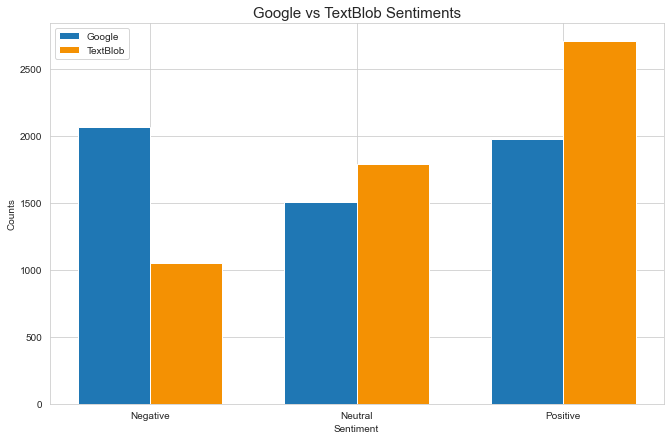

In [75]:
index = np.arange(3)
bar_width = 0.35

# get values in same order
g_vals = [ggl_vals[0], ggl_vals[2], ggl_vals[1]]
t_vals = [tb_vals[2], tb_vals[1], tb_vals[0]]

#plot
fig, ax = plt.subplots(figsize= (11,7))
google = ax.bar(index, g_vals, bar_width, label= 'Google')
textbb = ax.bar(index + bar_width, t_vals, bar_width, label= 'TextBlob', color='#f49103')

# set labels
ax.set_xlabel('Sentiment')
ax.set_ylabel('Counts')
ax.set_title('Google vs TextBlob Sentiments', fontsize = 15)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])

plt.legend()
plt.show()

We can see that Google's Natural Language Analysis and TextBlob's analysis yield different results.
* Google had almost twice as many negative Tweets as TextBlob
* TextBlob ranked 25% more Tweets as 'Positive'

In [76]:
# together_df.to_csv('data/google_tb_sentiments.csv', index= False)

## Classification Modeling
---
Time to vectorize and build some models!

In [77]:
data = pd.read_csv('data/text_sentiment_TextBlob.csv')

In [78]:
# create lists of only tweets or labels, convert tweets to unicode
X = data['tweets'].astype('U')
y = data['TB Sentiment']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

In [80]:
# use TweetTokenizer and TF IDF Vectorizer
def tokenize(tweet):
    tknzr = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
    return tknzr.tokenize(tweet)

tfidf_vect = TfidfVectorizer(stop_words= 'english', tokenizer= tokenize)

In [81]:
tfidf_Xtrain = tfidf_vect.fit_transform(X_train)
tfidf_Xtest = tfidf_vect.transform(X_test)

In [82]:
print('Xtest shape:', tfidf_Xtest.shape)
print('Xtrain shape:', tfidf_Xtrain.shape)

Xtest shape: (3715, 19746)
Xtrain shape: (14860, 19746)


### Building Models

In [83]:
# import necessary libraries for modeling
from sklearn.metrics import f1_score, accuracy_score, classification_report,\
confusion_matrix, roc_auc_score, plot_confusion_matrix, plot_roc_curve

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [84]:
# instantiate classifiers for vanilla models
classifiers = {
    'Logistic Regression' : LogisticRegression(max_iter=200), 
    'Random Forest' : RandomForestClassifier(), 
    'Support Vector Machine' : SVC(), 
    'XGBoost' : XGBClassifier(), 
    'Naive Bayes' : MultinomialNB()
}

In [85]:
# create DataFrame to hold results from vanilla models
# takes approx 2 mins to run
results = pd.DataFrame(columns= ['Train_accuracy', 'Test_accuracy', 
                                 'Weighted_F1_score'])

# predict, get accuracy and f1 scores and add to dataframe
conf_matrices = []
for key, value in classifiers.items():
    # fit models
    value.fit(tfidf_Xtrain, y_train)
    train_pred = value.predict(tfidf_Xtrain)
    y_pred = value.predict(tfidf_Xtest)
    
    # get accuracy, f1 score
    train_acc = accuracy_score(y_train, train_pred) * 100
    test_acc = accuracy_score(y_test, y_pred) * 100
    weight_f1 = f1_score(y_test, y_pred, average= 'weighted')
    
    # get false neg and true positive
    # add to confusion matrices list to view later if desired
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)
    
    # add measurements to datafram
    results.loc[key] = [round(train_acc, 2), round(test_acc, 2), 
                        round(weight_f1, 2)]

In [86]:
results.sort_values(by= ['Test_accuracy', 'Weighted_F1_score'], ascending= False)

,Train_accuracy,Test_accuracy,Weighted_F1_score
XGBoost,85.56,78.55,0.78
Support Vector Machine,98.57,76.93,0.76
Logistic Regression,90.67,76.88,0.76
Random Forest,99.89,76.53,0.75
Naive Bayes,70.90,62.26,0.56


Naive Bayes performed the worst while XGBoost performed the best with the least amount of overfitting. 

Next, let's tune some hyperparameters and see if we can get better results.

#### Hyperparameter Tuning

In [87]:
# function to get results after each model

def get_results(model, model_name):
    train_pred = model.predict(tfidf_Xtrain)
    y_pred = model.predict(tfidf_Xtest)
    
    # get classification report
    print('{} Classification Report'.format(model_name))
    print(classification_report(y_test, y_pred))
    
    # get confusion matrix
    plot_confusion_matrix(model, tfidf_Xtest, y_test, cmap= "Blues", 
                          values_format= '.5g')
    plt.grid(False)
    plt.title('{} Confusion Matrix'.format(model_name))
    plt.show()
    
    # get accuracy and F1 scores
    train_acc = accuracy_score(y_train, train_pred) * 100
    test_acc = accuracy_score(y_test, y_pred) * 100
    weight_f1 = f1_score(y_test, y_pred, average= 'weighted')
    
    #get false neg and true positive
    cm = confusion_matrix(y_test, y_pred)
    
    # save measurements into results df
    results.loc[model_name] = [round(train_acc, 2), round(test_acc, 2), 
                               round(weight_f1, 2)]

**XGBoost**

In [88]:
# set up hyperparameter grid
param_grid_xgb = {
    'learning_rate' : [0.05, 0.08, 0.1, 0.2],
    'max_depth' : [3, 4, 6, 8], 
    'min_child_weight' : [1, 2, 3]
}

In [89]:
# instantiate classifer, fit on model through randomized search
xgb = XGBClassifier(objective= 'softmax')
RS_xgb = RandomizedSearchCV(xgb, param_grid_xgb, scoring= 'f1_weighted', random_state= 27)
RS_xgb.fit(tfidf_Xtrain, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='softmax',
                                           random_state=None, reg

In [90]:
RS_xgb.best_params_

{'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.2}

RS XGBoost Classification Report
              precision    recall  f1-score   support

    Negative       0.82      0.47      0.60       639
     Neutral       0.70      0.86      0.77      1176
    Positive       0.81      0.81      0.81      1900

    accuracy                           0.77      3715
   macro avg       0.78      0.71      0.73      3715
weighted avg       0.78      0.77      0.76      3715



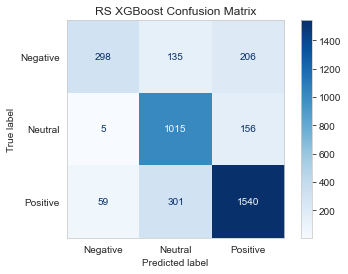

In [91]:
get_results(RS_xgb, 'RS XGBoost')

In [92]:
# original confusion matrix that was not tuned
conf_matrices[3]

array([[ 326,  132,  181],
       [   7, 1044,  125],
       [  65,  287, 1548]])

**Random Forest**

In [93]:
param_grid_rf = {
    'n_estimators' : [100, 150], 
    'max_depth' : [100, 120], 
    'min_samples_split' : [2, 4, 8], 
    'min_samples_leaf' : [3, 5]
}

In [94]:
rf = RandomForestClassifier()
RS_rf = RandomizedSearchCV(rf, param_grid_rf, n_iter= 20, scoring= 'f1_weighted', 
                          random_state= 27)
RS_rf.fit(tfidf_Xtrain, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [100, 120],
                                        'min_samples_leaf': [3, 5],
                                        'min_samples_split': [2, 4, 8],
                                        'n_estimators': [100, 150]},
                   random_state=27, scoring='f1_weighted')

In [95]:
RS_rf.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_depth': 120}

RS Random Forest Classification Report
              precision    recall  f1-score   support

    Negative       0.94      0.23      0.37       639
     Neutral       0.75      0.73      0.74      1176
    Positive       0.71      0.89      0.79      1900

    accuracy                           0.73      3715
   macro avg       0.80      0.62      0.63      3715
weighted avg       0.76      0.73      0.70      3715



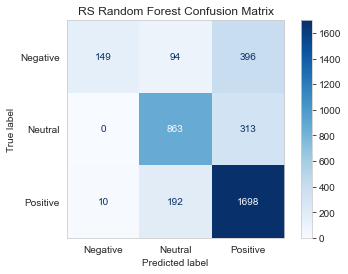

In [96]:
get_results(RS_rf, 'RS Random Forest')

**Support Vector Machines**

In [97]:
param_grid_svc = {
    'kernel': ['rbf'], 
    'gamma': ['scale', 1e-3, 1e-4, 1e-5],
    'C': [1, 10, 100]
}

In [98]:
svc = SVC()
RS_svc = RandomizedSearchCV(svc, param_grid_svc, scoring= 'f1_weighted')
RS_svc.fit(tfidf_Xtrain, y_train)

RandomizedSearchCV(estimator=SVC(),
                   param_distributions={'C': [1, 10, 100],
                                        'gamma': ['scale', 0.001, 0.0001,
                                                  1e-05],
                                        'kernel': ['rbf']},
                   scoring='f1_weighted')

In [99]:
RS_svc.best_params_

{'kernel': 'rbf', 'gamma': 'scale', 'C': 10}

RS Support VM Classification Report
              precision    recall  f1-score   support

    Negative       0.77      0.52      0.62       639
     Neutral       0.78      0.80      0.79      1176
    Positive       0.79      0.87      0.83      1900

    accuracy                           0.79      3715
   macro avg       0.78      0.73      0.75      3715
weighted avg       0.78      0.79      0.78      3715



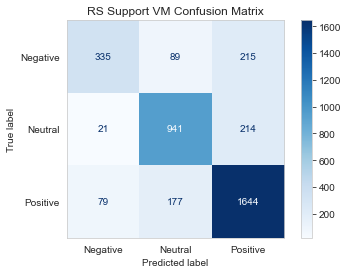

In [100]:
get_results(RS_svc, 'RS Support VM')

**Logistic Regression**

In [101]:
param_grid_lg = {
    'penalty' : ['l2'], 
    'C': [0.05, 0.1, 1], 
    'class_weight' : [None, 'balanced'],
    'random_state' : [27], 
    'max_iter' : [200]
}

In [102]:
lg = LogisticRegression()
GS_lg = GridSearchCV(lg, param_grid_lg, scoring= 'f1_weighted')
GS_lg.fit(tfidf_Xtrain, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.05, 0.1, 1],
                         'class_weight': [None, 'balanced'], 'max_iter': [200],
                         'penalty': ['l2'], 'random_state': [27]},
             scoring='f1_weighted')

In [103]:
GS_lg.best_params_

{'C': 1,
 'class_weight': 'balanced',
 'max_iter': 200,
 'penalty': 'l2',
 'random_state': 27}

GS Logistic Regression Classification Report
              precision    recall  f1-score   support

    Negative       0.59      0.71      0.64       639
     Neutral       0.73      0.83      0.77      1176
    Positive       0.88      0.74      0.81      1900

    accuracy                           0.76      3715
   macro avg       0.73      0.76      0.74      3715
weighted avg       0.78      0.76      0.77      3715



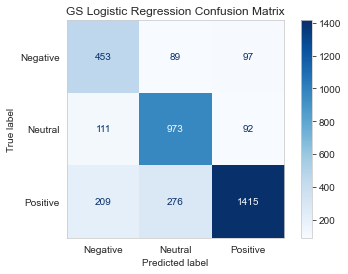

In [104]:
get_results(GS_lg, 'GS Logistic Regression')

## Results

In [105]:
results = results.sort_values(by= ['Test_accuracy', 'Weighted_F1_score'], ascending= False)
results

,Train_accuracy,Test_accuracy,Weighted_F1_score
RS Support VM,99.89,78.60,0.78
XGBoost,85.56,78.55,0.78
Support Vector Machine,98.57,76.93,0.76
Logistic Regression,90.67,76.88,0.76
RS XGBoost,82.36,76.80,0.76
Random Forest,99.89,76.53,0.75
GS Logistic Regression,90.88,76.47,0.77
RS Random Forest,76.96,72.95,0.70
Naive Bayes,70.90,62.26,0.56


### Plots

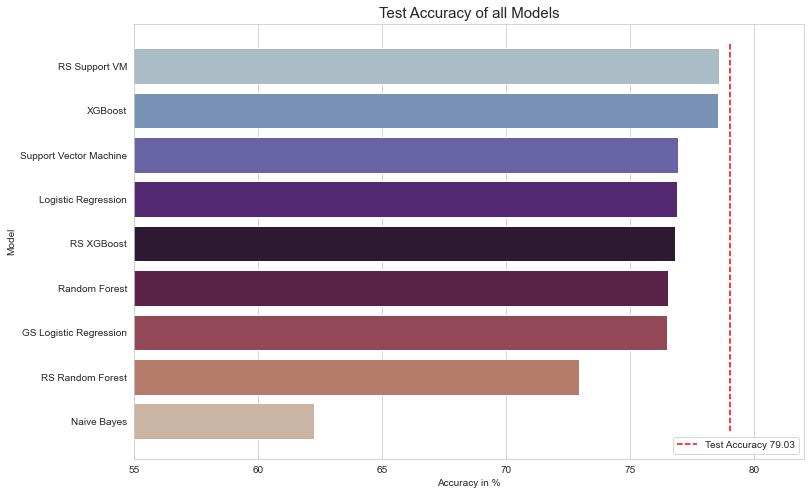

In [106]:
# plot test accuracy
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x= results['Test_accuracy'], y= results.index, palette = 'twilight')
plt.vlines(x= 79.03, ymin = -.5, ymax= 8.25, linestyles= 'dashed', color = 'r', label= 'Test Accuracy 79.03')
plt.title('Test Accuracy of all Models', fontsize= 15)
plt.ylabel('Model')
plt.xlabel('Accuracy in %')
plt.xlim(55, 82)
ax.legend(loc = 'lower right')
plt.show()

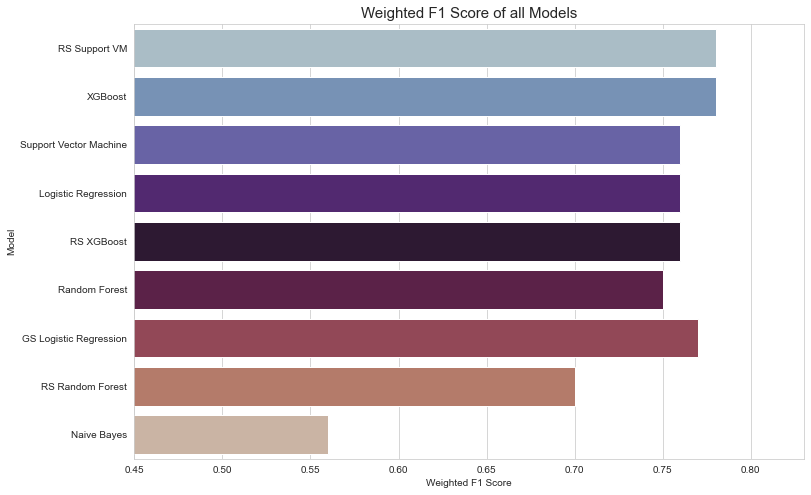

In [107]:
# plot weighted f1 score
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x= results['Weighted_F1_score'], y= results.index, 
            palette = 'twilight')
plt.title('Weighted F1 Score of all Models', fontsize= 15)
plt.ylabel('Model')
plt.xlabel('Weighted F1 Score')
plt.xlim(0.45, 0.83)
plt.show()

### Feature Extraction 

In [108]:
# function to calculate and plot feature extraction from TF-IDF vector
def plot_most_predictive_features(vectorizer):
    x_train = vectorizer.fit_transform(X_train)
    x_test = vectorizer.transform(X_test)
    chi2_score = chi2(x_train, y_train)[0]
    
    scores = list(zip(vectorizer.get_feature_names(), chi2_score))
    wchi2 = sorted(scores, key=lambda x:x[1])
    #pick top 20
    top_chi2 = list(zip(*wchi2[-20:]))
    
    # color list
    colors = ['#f8d3d4', '#fad8d1', '#f4bdbf', '#f8c4b9', '#f1a7aa', 
              '#f6b0a2', '#ed9194', '#f18974', '#e4585d', '#ea4a2a']
    
    # plot 
    plt.figure(figsize=(15,10))
    x = range(len(top_chi2[1]))
    labels = top_chi2[0]
    plt.barh(x,top_chi2[1], align='center', color = colors)
    plt.yticks(x, labels)
    plt.xlabel('$\chi^2$')
    plt.title('Top 20 Predictive Features Based on Chi-Square Scores', 
              fontsize = 16, fontweight = 'bold')

_Why use Chi-Square Statistic?_

The Chi Square statistic is commonly used for testing relationships between categorical variables.  The null hypothesis of the Chi-Square test is that no relationship exists on the categorical variables in the population; they are independent. 

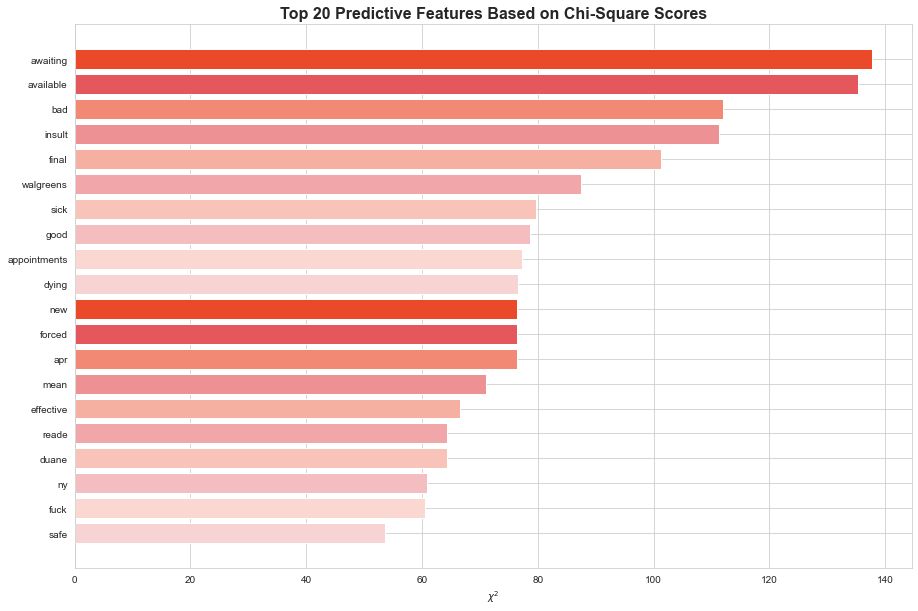

In [109]:
plot_most_predictive_features(tfidf_vect)

## Conclusion

The tuned SVM model was the most accurate model at predicting the sentiment of Tweets. Logistic Regression, either tuned or with no hyperparameters, was also able to decently predict COVID-19 vaccine sentiments.

## Future Work

Future work would include adding Word2Vec and GPT-3.